In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Silhouette Score for 2 clusters: 0.10678310798259613
Silhouette Score for 3 clusters: 0.17801363839754997
Silhouette Score for 4 clusters: 0.21262496310319895
Silhouette Score for 5 clusters: 0.2335466840348004
Silhouette Score for 6 clusters: 0.20364573614233805
Silhouette Score for 7 clusters: 0.17515335907270096
Silhouette Score for 8 clusters: 0.12992705554669656
Silhouette Score for 9 clusters: 0.13093406458749923
Silhouette Score for clustering: 0.23


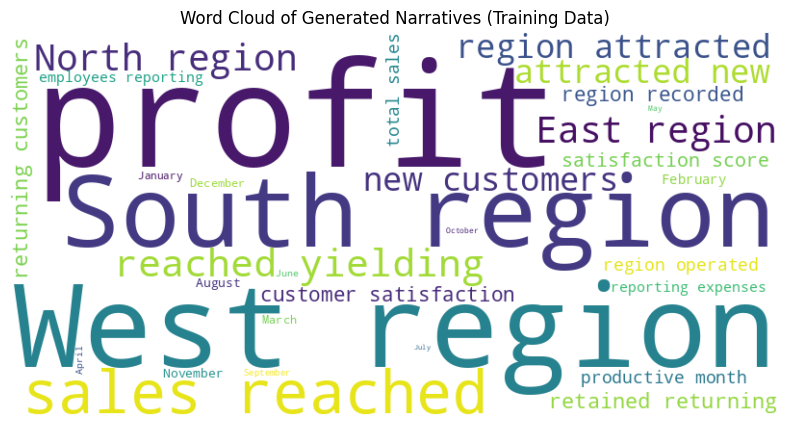

Train dataset with narratives saved to /content/drive/MyDrive/train_narrative_output.csv
Test dataset with narratives saved to /content/drive/MyDrive/test_narrative_output.csv


In [ ]:
import pandas as pd
import random
from textblob import TextBlob  # For sentiment analysis
from sklearn.feature_extraction.text import TfidfVectorizer  # For TF-IDF
from sklearn.cluster import KMeans  # For clustering
from wordcloud import WordCloud  # For word cloud visualization
from sklearn.model_selection import train_test_split  # For splitting the dataset
from sklearn.metrics import silhouette_score  # For evaluating cluster
from scipy.optimize import linear_sum_assignment  # For optimal label matching
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer  # For VADER sentiment analysis
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess the dataset
def preprocess_data(file_path):
    """Load and preprocess the dataset."""
    df = pd.read_csv(file_path)

    # Check for missing values
    if df.isnull().sum().any():
        df = df.fillna(method='ffill')

    # Convert columns to appropriate data types (if necessary)
    numeric_columns = ['Sales', 'Profit', 'Expenses', 'Customer_Satisfaction', 'Employee_Count', 'New_Customers', 'Returning_Customers']
    for col in numeric_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Ensure consistency in Region and Month values
    df['Region'] = df['Region'].str.strip().str.title()
    df['Month'] = df['Month'].str.strip().str.title()

    return df

# Function to generate narratives
def generate_narrative(row):
    templates = [
        f"In the {row['Region']} region during {row['Month']}, sales reached ${row['Sales']:,}, yielding a profit of ${row['Profit']:,}.",
        f"{row['Month']} was a productive month for the {row['Region']} region with total sales of ${row['Sales']:,} and profits of ${row['Profit']:,}.",
        f"The {row['Region']} region recorded a customer satisfaction score of {row['Customer_Satisfaction']} in {row['Month']}.",
        f"During {row['Month']}, the {row['Region']} region attracted {row['New_Customers']} new customers and retained {row['Returning_Customers']} returning customers.",
        f"In {row['Month']}, the {row['Region']} region operated with {row['Employee_Count']} employees, reporting expenses of ${row['Expenses']:,}."
    ]
    return random.choice(templates)

# Sentiment Analysis using VADER
def analyze_sentiment_vader(narrative):
    """Analyze sentiment polarity using VADER."""
    analyzer = SentimentIntensityAnalyzer()
    sentiment_scores = analyzer.polarity_scores(narrative)
    return sentiment_scores['compound'], sentiment_scores['pos'], sentiment_scores['neu'], sentiment_scores['neg']

# Function for optimal cluster-label matching
def match_clusters_to_labels(true_labels, predicted_labels):
    """Find the best match between predicted clusters and true labels."""
    contingency_matrix = pd.crosstab(true_labels, predicted_labels)
    row_ind, col_ind = linear_sum_assignment(-contingency_matrix.values)
    mapping = {col: row for col, row in zip(col_ind, row_ind)}
    return [mapping[label] for label in predicted_labels]

# File paths
input_file_path = '/content/drive/MyDrive/narrative_generation_large_dataset.csv'
output_file_path = '/content/drive/MyDrive/narrative_output_with_analytics.csv'

# Preprocess the dataset
df = preprocess_data(input_file_path)

# Generate narratives
df['Narrative'] = df.apply(generate_narrative, axis=1)

# Analyze sentiment using VADER
df[['Sentiment_Compound', 'Sentiment_Pos', 'Sentiment_Neu', 'Sentiment_Neg']] = df['Narrative'].apply(
    lambda x: pd.Series(analyze_sentiment_vader(x))
)

# Train-test split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Keyword Extraction using TF-IDF on training data
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix_train = tfidf_vectorizer.fit_transform(train_df['Narrative'])
tfidf_matrix_test = tfidf_vectorizer.transform(test_df['Narrative'])

# Determine optimal number of clusters
for n_clusters in range(2, 10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(tfidf_matrix_train)
    silhouette_avg = silhouette_score(tfidf_matrix_train, cluster_labels)
    print(f"Silhouette Score for {n_clusters} clusters: {silhouette_avg}")

# Clustering Narratives (using optimal number of clusters, e.g., 3)
num_clusters = 5  # Replace with the optimal number identified
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
train_df['Cluster'] = kmeans.fit_predict(tfidf_matrix_train)
test_df['Cluster'] = kmeans.predict(tfidf_matrix_test)

# Evaluate clustering using Silhouette Score
silhouette_avg = silhouette_score(tfidf_matrix_train, train_df['Cluster'])
print(f"Silhouette Score for clustering: {silhouette_avg:.2f}")

# Optimal cluster-label matching for accuracy calculation
if 'True_Cluster' in train_df.columns:
    train_df['Matched_Cluster'] = match_clusters_to_labels(train_df['True_Cluster'], train_df['Cluster'])
    clustering_accuracy = (train_df['Matched_Cluster'] == train_df['True_Cluster']).mean()
    print(f"Clustering accuracy after label matching: {clustering_accuracy:.2f}")

# Word Cloud Generation for Visualization (based on training data)
all_text_train = " ".join(train_df['Narrative'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text_train)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Generated Narratives (Training Data)")
plt.show()

# Save the enhanced datasets to new CSV files
train_output_file_path = '/content/drive/MyDrive/train_narrative_output.csv'
test_output_file_path = '/content/drive/MyDrive/test_narrative_output.csv'
train_df.to_csv(train_output_file_path, index=False)
test_df.to_csv(test_output_file_path, index=False)

print(f"Train dataset with narratives saved to {train_output_file_path}")
print(f"Test dataset with narratives saved to {test_output_file_path}")


In [ ]:
pip install --upgrade scipy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 15.6 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.14.1 which is incompatible.


In [ ]:
from scipy.optimize import linear_sum_assignment


In [ ]:
pip install vaderSentiment


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 4.5 MB/s eta 0:00:00


In [ ]:
pip uninstall scipy numpy
pip install --no-cache-dir scipy numpy


SyntaxError: invalid syntax (<ipython-input-11-fc3a2444d48e>, line 1)